In [1]:
!pip install cirq

     |████████████████████████████████| 1.6 MB 5.3 MB/s 
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 437 kB 53.2 MB/s 
     |████████████████████████████████| 47 kB 4.0 MB/s 
     |████████████████████████████████| 328 kB 66.4 MB/s 
     |████████████████████████████████| 145 kB 45.6 MB/s 
     |████████████████████████████████| 97 kB 5.9 MB/s 
     |████████████████████████████████| 65 kB 3.1 MB/s 
     |████████████████████████████████| 10.1 MB 36.5 MB/s 
     |████████████████████████████████| 220 kB 41.3 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 229 kB 43.5 MB/s 
     |████████████████████████████████| 243 kB 43.3 MB/s 
     |████████████████████████

In [2]:
import numpy as np
import random
import time
import itertools as itert
import matplotlib.pyplot as plt
import cirq
from tqdm.notebook import tqdm


QAOA

In [3]:
#Generates a random 2CNF given m,n
def getFx(m,n,verbose = True):  
  lis = [] 
  coun = 0
  all_tups = []
  while(coun<m):
    s = np.random.choice(n, 2, replace=True)
    s = s + 1
  
    sig = np.random.randint(2, size = 2)*2-1
    s = sorted(s*sig)
    if(tuple(s) not in all_tups):
      all_tups.append(tuple(s))
      lis.append(list(s))
      coun += 1
  return lis



In [4]:
lis = getFx(10,2)  
print(lis)

[[-1, -1], [-2, 1], [-1, 1], [-2, 2], [-1, 2], [1, 1], [-2, -1], [-2, -2], [2, 2], [1, 2]]


In [5]:
#Solver which solves the 2CNF and outputs all possible solution and max count
def solve(lis,n):
  dic = {}
  maxx = -1e10
  max_lis = []
  
  for i in range(2**n):
    val = bin(i)[2:].zfill(n)
    list_val = np.asarray(list(map(int,val)))*2-1
    summ = 0
    for j in range(len(lis)):
      summ += (np.sign(list_val[abs(lis[j][0])-1]) == np.sign(lis[j][0])) or (np.sign(list_val[abs(lis[j][1])-1]) == np.sign(lis[j][1]))
    
    dic[val] = summ
  for i in range(2**n):
    val = bin(i)[2:].zfill(n)
  
    if(dic[val]==max(dic.values())):
      max_lis.append(val)
  return max_lis,max(dic.values())    
 


In [6]:
#classical solver which outputs 1 if atleast t clauses satisfied
def classical(lis,n,t):
  outs,outs2 = solve(lis,n)
  if(outs2>=t):
    return 1
  else: 
    return 0  


In [7]:
a = classical(lis,2,10)
print("Output:", a)


Output: 0


In [8]:

# Generate mixer matrix
def createMixer(n,beta):
    R = np.array([[np.cos(beta),-1j*np.sin(beta)],[-1j*np.sin(beta),np.cos(beta)]])

    return R
   


# Oracle to generate the quantum gate given the  matrix        
class Oracle(cirq.Gate):
    def __init__(self, n, ufMatrix, name):
        self.__n = n
        self.__ufMatrix = ufMatrix
        self.__name = name

    def num_qubits(self):
        return self.__n 

    def _unitary_(self):
        return np.squeeze(np.asarray(self.__ufMatrix))
        
    def __str__(self):
        return self.__name

In [9]:
#Gamma matrix
def gamma_matrix(size, gamma):
  matrix_R = np.identity(size, dtype=complex)
  matrix_R[-1][-1] = np.exp(-1j*gamma)
  return matrix_R

In [10]:
# creating possible seperator gates used in circuit
def obtain_gamma_gates(gamma):
  gate1_rgamma = Oracle(1,gamma_matrix(2, gamma),"R")
  gate2_crgamma = Oracle(2, gamma_matrix(4, -1*gamma), "CR")
  gate3_ccrgamma = Oracle(3,gamma_matrix(8, -1*gamma),"CCR")
  return gate1_rgamma, gate2_crgamma, gate3_ccrgamma

In [11]:
# creating one unit of circuit for a particular clause
def utility_helper(circuit, line1, line2, qubits, gate1_rgamma, gate2_crgamma, gate3_ccrgamma):
  if(line1 == line2):
    circuit.append([cirq.X.on(qubits[line1])])
    circuit.append([gate1_rgamma.on(qubits[-1])])
    circuit.append([gate2_crgamma.on(qubits[-1], qubits[line1])])
    circuit.append([cirq.X.on(qubits[line1])])
  else:
    circuit.append([cirq.X.on(qubits[line1])])
    circuit.append([cirq.X.on(qubits[line2])])
    circuit.append([gate1_rgamma.on(qubits[-1])])
    circuit.append([gate3_ccrgamma.on(qubits[-1], qubits[line1],qubits[line2])])
    circuit.append([cirq.X.on(qubits[line1])])
    circuit.append([cirq.X.on(qubits[line2])])
  return circuit

In [12]:
# creating the whole seperator circuit
def separator_utility(circuit, first, second, qubits, gamma):
  # parsing
  line1 = np.abs(first) - 1
  line2 = np.abs(second) - 1
  gate1_rgamma, gate2_crgamma, gate3_ccrgamma = obtain_gamma_gates(gamma)
  # Negating the qubits
  if(first < 0):
    #meaning the literal is negated
    circuit.append([cirq.X.on(qubits[line1])])
  if(line2!=line1 and second<0):
    circuit.append([cirq.X.on(qubits[line2])])
  
  circuit = utility_helper(circuit, line1, line2, qubits, gate1_rgamma, gate2_crgamma, gate3_ccrgamma)
  
  # Undoing negation of qubits
  if(first < 0):
    #meaning the literal is negated
    circuit.append([cirq.X.on(qubits[line1])])  
  if(line2!=line1 and second<0):
    circuit.append([cirq.X.on(qubits[line2])])
  return circuit

In [13]:
def runMainCircuit(n,m,t,lis,beta_divs = 5,gamma_divs = 5,repeats=1, verbose = True):
  if(t>m):
    print("Incorrect input parameters, t should be less than equal to number of clauses")
    return 0,0,0,0,0,0,0
  qubits = cirq.LineQubit.range(n+1) # for helper also
 
  
  c = cirq.Circuit()
  # dividing beta space
  betas = np.arange(beta_divs+1)*np.pi/(beta_divs)
  # dividing gamma space
  gamas = 2*np.arange(gamma_divs+1)*np.pi/(gamma_divs)

  # Applying hadamard gates
  for i in range(0,n):
      c.append([cirq.H(qubits[i])])
  
  # add X gate in front of helper qubit 
  c.append(cirq.X(qubits[-1]))   
 
  
  temp_c = c.copy()    
 
  if(lis==[]):

    lis = getFx(m,n)
  #Solving the given 2CNF classically
  aa,bb = solve(lis,n)

  if(verbose):
      print("#######################")
      print("2-CNF generated:")
      print(lis)
  if(verbose):
    print("Solution:", aa)
    print("Count",bb)
    print("#######################")

    

  flag = 0
  
  max_good = -1e10
  curr_max = -1e10
 
  global_sep = 0
  global_rest_c = 0
  global_exec = 0
  for i in range(len(betas)):
     
    u_beta = createMixer(n,betas[i])
    # generating n copies of mixer gates
    u_beta_o= [Oracle(1, u_beta, "Mixer") for mm in range(n)]

    for j in range(len(gamas)):
      start = time.time()  
 
      temp_c = c.copy() 

      # Applying Separator

      for iter in range(m):
        first, second = lis[iter]
        if(first != -1*second):
          temp_c = separator_utility(temp_c, first, second, qubits, gamas[j]) 
      mid1 = time.time()    

      
      # Applying Mixer

      for b1 in range(0,n):
        temp_c.append([u_beta_o[b1].on(qubits[b1])])

      # Measure
      for l in range(0,n):
        temp_c.append(cirq.measure(qubits[l]))




      
      if(verbose and i==0 and j==0):
        print("Quantum Circuit:")
        print(temp_c)
        print("#######################")

      mid2 = time.time() 

      simulator = cirq.Simulator()
    
      
      result = simulator.run(temp_c, repetitions = repeats)
      
      dic = result._measurements

      bit_strings = (np.asarray(list(dic.values())).squeeze().T)*2-1
      
      
      if(repeats==1):
        bit_strings = np.expand_dims(bit_strings,0)

      elif(len(bit_strings.shape)==1):
        bit_strings = np.expand_dims(bit_strings,1)

      good_counts = 0
      for zz in range(len(bit_strings)):
        summ = 0
        for pp in range(len(lis)):
          
          summ += (np.sign(bit_strings[zz][abs(lis[pp][0])-1]) == np.sign(lis[pp][0])) or (np.sign(bit_strings[zz][abs(lis[pp][1])-1]) == np.sign(lis[pp][1]))
        if(summ>=t):
          flag = 1
          good_counts += 1
        # getting the highest count and correpsonding bit string  
        if(summ>curr_max):
          sol = bit_strings[zz]
          curr_max = summ
      # getting list of bit strings for the run when highest clauses satisfied count was highest
      if(good_counts>=max_good):
        max_good = good_counts    
        final_bit = bit_strings 

     
       

      
      end = time.time() 
      global_sep += (mid1-start)
      global_rest_c += (mid2-mid1)
      global_exec += (end-mid2)
      



    
  return flag, final_bit, sol, curr_max, global_sep, global_rest_c, global_exec
         

      
      


In [14]:
#process string to generate the histogram of values for best beta and gamma
def process_string(bit,n):

  dic = {}
  for i in range(len(bit)):
    bit[i][np.where(bit[i]<0)] = 0

    curr = "".join(list(map(str,bit[i])))
    if(curr not in dic):
      dic[curr] = 1
    else:
      dic[curr] += 1  

  plt.bar(dic.keys(),dic.values())
  
  plt.xticks(rotation='vertical')


  return plt

Analysis Starts

#######################
2-CNF generated:
[[-1, 2], [-3, -2], [-3, -1], [-2, 4], [-4, 2], [-3, 2], [-3, 1], [-2, 2], [-2, -1], [-4, -3], [1, 1], [2, 3], [-4, -2], [-1, 4], [-3, 3], [-2, 3], [1, 3], [1, 2], [-3, 4], [3, 4]]
Solution: ['1001', '1101']
Count 17
#######################
Quantum Circuit:
                                                                    ┌────┐                             ┌────┐                                     ┌────┐                 ┌───┐       ┌────┐                                 ┌────┐       ┌────┐           ┌────┐           ┌────┐
0: ───H───X───X───#2────X───X───X───X─────────────────────#3────X────X───────X──────────────────────────────────────────────────#3────X───X───X────#3──────X───X─────X─────#2────X────X───────X──────────────────────────────#2──────X────X───────X────────#2──────X───X────#2──────X───Mixer───M─────────────────────────────────
                  │                                       │                                             

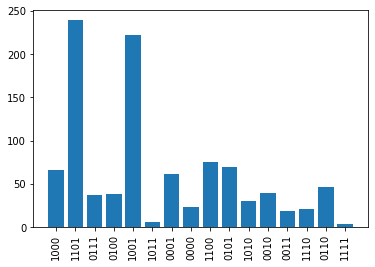

In [28]:
dic = {0:"does not exist",1: "exists"}
n = 4
m = 20
lis_sam = getFx(m,n,verbose = True)

dd,a = solve(lis_sam,n)

t = a
result, histo, solution, max_count, cir_time1,cir_time2, exec_time = runMainCircuit(n,m,t,lis_sam,repeats=1000,verbose = True)

if(result>0):
  solution[np.where(solution<0)] = 0
  fin = ""
  for nn in range(len(solution)):
    fin = fin + str(solution[nn])

  
  


  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")
  print("One of the Assignment which maximizes count = ", fin)
  print("Number of clauses satisfied",max_count)
  print("Time taken for circuit creation", cir_time1+cir_time2)
  print("Time taken for execution", exec_time)
  print("Total Time taken",cir_time1+cir_time2+exec_time)
  print("Histogram of assignments for 1000 repititions")
  pt= process_string(histo,n)

else:
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")



In [30]:
dic = {0:"does not exist",1: "exists"}
n = 4
m = 4
lis_sam = getFx(m,n,verbose = True)

dd,a = solve(lis_sam,n)

t = a
result, histo, solution, max_count, cir_time1,cir_time2, exec_time = runMainCircuit(n,m,t,lis_sam,repeats=1000,verbose = True)

if(result>0):
  solution[np.where(solution<0)] = 0
  fin = ""
  for nn in range(len(solution)):
    fin = fin + str(solution[nn])


  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")
  print("One of the Assignment which maximizes count = ", fin)
  print("Number of clauses satisfied",max_count)
  print("Time taken for circuit creation", cir_time1+cir_time2)
  print("Time taken for execution", exec_time)
  print("Total Time taken",cir_time1+cir_time2+exec_time)

else:
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")

#######################
2-CNF generated:
[[-1, 4], [-1, 2], [2, 3], [-3, 4]]
Solution: ['0011', '0100', '0101', '0111', '1101', '1111']
Count 4
#######################
Quantum Circuit:
0: ───H───X───X───#2────X───X───X───X───#2────X───X───Mixer───M─────────────────────────────────────────────
                  │                     │
1: ───H───X───────┼─────────────────────#3────X───X───#2──────X───Mixer───M─────────────────────────────────
                  │                     │             │
2: ───H───X───────┼─────────────────────┼─────────────#3──────X───X───────X───#2────X───X───────Mixer───M───
                  │                     │             │                       │
3: ───H───X───────#3────X───X───────────┼─────────────┼───────────────────────#3────X───Mixer───M───────────
                  │                     │             │                       │
4: ───X───R───────CCR───R───────────────CCR───R───────CCR─────R───────────────CCR───────────────────────────
############

In [31]:
dic = {0:"does not exist",1: "exists"}
n = 2
m = 4
t = 4

result, histo, solution, max_count, cir_time1,cir_time2, exec_time = runMainCircuit(n,m,t,[],verbose = True)

if(result>0):
  solution[np.where(solution<0)] = 0
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")
  print("One of the Assignment which maximizes count = ", solution)
  print("Number of clauses satisfied",max_count)
  print("Time taken for circuit creation", cir_time1+cir_time2)
  print("Time taken for execution", exec_time)
  print("Total Time taken",cir_time1+cir_time2+exec_time)
 
else:
  print("Quantum Circuit Output:")
  print("There {}".format(dic[result])+" z satisfies {}".format(t) + " clauses")


#######################
2-CNF generated:
[[2, 2], [-2, 2], [-2, -2], [-1, -1]]
Solution: ['00', '01']
Count 3
#######################
Quantum Circuit:
                                        ┌───┐
0: ───H───X───X───────────────────────────#2────X───────X───Mixer───M───
                                          │
1: ───H───X───#2───X───X───X───#2───X────X┼─────Mixer───M───────────────
              │                │          │
2: ───X───R───CR───R───────────CR───R─────CR────────────────────────────
                                        └───┘
#######################
Quantum Circuit Output:
There does not exist z satisfies 4 clauses


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

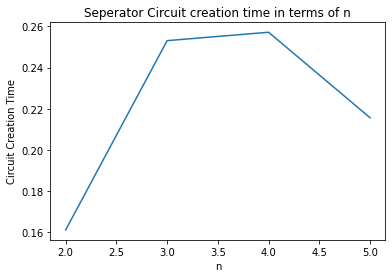

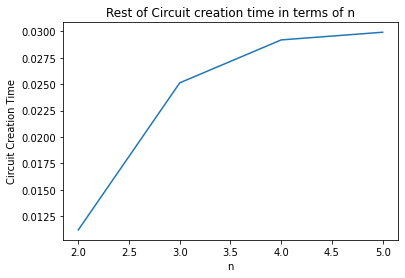

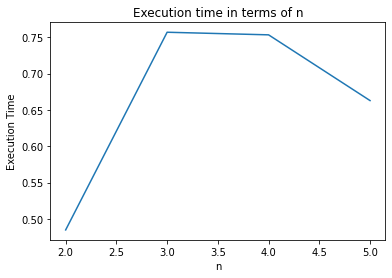

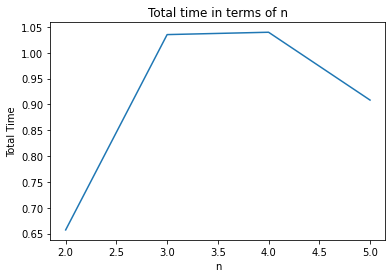

In [32]:
# Variation of Time vs number of variables
n = 5
m = 10
t = 8

n_c1_time = []
n_c2_time = []
n_e_time = []
total_time = []
inside_repeats = 10
n_axis = np.arange(1,n)+1
for i in tqdm(range(2,n+1)):
  temp_cirq1_time = 0
  temp_cirq2_time =0 
  temp_exec_time = 0
  for j in tqdm(range(inside_repeats)):
  
    result, histo, solution, max_count, cir_time1, cir_time2 , exec_time = runMainCircuit(i,m,t,[],verbose = False)
    temp_cirq1_time += cir_time1
    temp_cirq2_time += cir_time2
    temp_exec_time += exec_time
    
  temp_cirq1_time /= inside_repeats
  temp_cirq2_time /= inside_repeats
  temp_exec_time /= inside_repeats
  n_c1_time.append(temp_cirq1_time)
  n_c2_time.append(temp_cirq2_time)
  n_e_time.append(temp_exec_time)
  total_time.append(temp_cirq1_time+temp_cirq2_time+temp_exec_time)

plt.plot(n_axis, n_c1_time)  
plt.title('Seperator Circuit creation time in terms of n')
plt.ylabel('Circuit Creation Time')
plt.xlabel('n')
plt.show() 

plt.plot(n_axis, n_c2_time)  
plt.title('Rest of Circuit creation time in terms of n')
plt.ylabel('Circuit Creation Time')
plt.xlabel('n')
plt.show()

plt.plot(n_axis, n_e_time)  
plt.title('Execution time in terms of n')
plt.ylabel('Execution Time')
plt.xlabel('n')
plt.show()  


plt.plot(n_axis,total_time)  
plt.title('Total time in terms of n')
plt.ylabel('Total Time')
plt.xlabel('n')
plt.show()  

  0%|          | 0/6 [00:00<?, ?it/s]

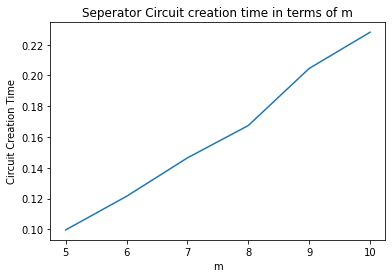

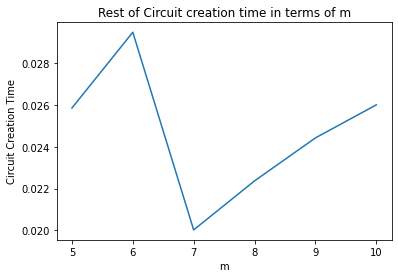

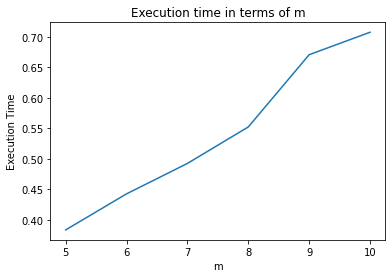

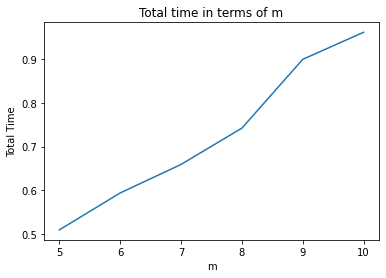

In [33]:
# Variation of Time vs number of clauses
n = 4
m = 10
t = 3
lis_m = getFx(m,n,verbose = True)
n_c1_time = []
n_c2_time = []
n_e_time = []
total_time = []
inside_repeats = 5
n_axis = np.arange(4,m)+1
for i in tqdm(range(5,m+1)):
  temp_cirq1_time = 0
  temp_cirq2_time =0 
  temp_exec_time = 0
  for j in (range(inside_repeats)):
    result, histo, solution, max_count, cir_time1, cir_time2 , exec_time = runMainCircuit(n,i,t,lis_m[:i],verbose = False)
    temp_cirq1_time += cir_time1
    temp_cirq2_time += cir_time2
    temp_exec_time += exec_time
    
  temp_cirq1_time /= inside_repeats
  temp_cirq2_time /= inside_repeats
  temp_exec_time /= inside_repeats
  n_c1_time.append(temp_cirq1_time)
  n_c2_time.append(temp_cirq2_time)
  n_e_time.append(temp_exec_time)
  total_time.append(temp_cirq1_time+temp_cirq2_time+temp_exec_time)

plt.plot(n_axis, n_c1_time)  
plt.title('Seperator Circuit creation time in terms of m')
plt.ylabel('Circuit Creation Time')
plt.xlabel('m')
plt.show() 

plt.plot(n_axis, n_c2_time)  
plt.title('Rest of Circuit creation time in terms of m')
plt.ylabel('Circuit Creation Time')
plt.xlabel('m')
plt.show()

plt.plot(n_axis, n_e_time)  
plt.title('Execution time in terms of m')
plt.ylabel('Execution Time')
plt.xlabel('m')
plt.show()  


plt.plot(n_axis,total_time)  
plt.title('Total time in terms of m')
plt.ylabel('Total Time')
plt.xlabel('m')
plt.show()  

  0%|          | 0/7 [00:00<?, ?it/s]

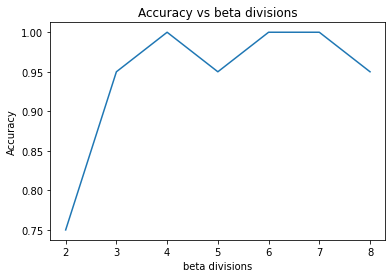

In [34]:
# Variation of Accuracy vs beta division
n = 4
m = 10
lis = []
divs = np.arange(2,9)
repeats_beta = 20
bet_accr = []
for i in range(repeats_beta):
  lis.append(getFx(m,n))

for i in tqdm(range(len(divs))):
  accr = 0
  for t in range(repeats_beta):
    
    _,a = solve(lis[t],n)

    c1 = classical(lis[t],n,a)

    c2,_,_,_,_,_,_ = runMainCircuit(n,m,a,lis[t],beta_divs = divs[i],verbose = False)
  
    if(c1==c2):
      accr += 1
  accr /=  repeats_beta


  bet_accr.append(accr)

plt.plot(divs,bet_accr)  
plt.title('Accuracy vs beta divisions')
plt.ylabel('Accuracy')
plt.xlabel('beta divisions')
plt.show()  



  0%|          | 0/7 [00:00<?, ?it/s]

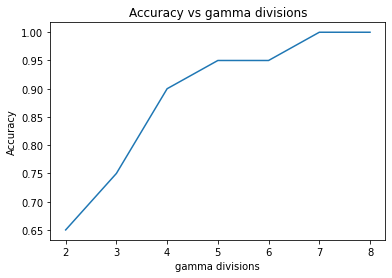

In [39]:
# Variation of accuracy vs gamma division
n = 4
m = 10
lis = []
divs = np.arange(2,9)
repeats_gam = 20
gam_accr = []
for i in range(repeats_gam):
  lis.append(getFx(m,n))

for i in tqdm(range(len(divs))):
  accr = 0
  for t in range(repeats_gam):
    
    _,a = solve(lis[t],n)

    c1 = classical(lis[t],n,a)

    c2,_,_,_,_,_,_ = runMainCircuit(n,m,a,lis[t],gamma_divs = divs[i],verbose = False)
  
    if(c1==c2):
      accr += 1
  accr /=  repeats_gam


  gam_accr.append(accr)

plt.plot(divs,gam_accr)  
plt.title('Accuracy vs gamma divisions')
plt.ylabel('Accuracy')
plt.xlabel('gamma divisions')
plt.show()    